<a href="https://colab.research.google.com/github/WetSuiteLeiden/example-notebooks/blob/main/datasets/dataset_intro_by_doing__kansspelautoriteit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# (only) in colab, run this first to install wetsuite from (the most recent) source. 
#    (this should soon simplify to something like   !pip3 install --upgrade wetsuite)
# For your own setup, see wetsuite's install guidelines.
!pip3 install -U wetsuite

# Purpose of this notebook



To show you around the dataset from the [kansspelautoriteit](https://kansspelautoriteit.nl/)'s [sanctiebesluiten](https://kansspelautoriteit.nl/aanpak-misstanden/sanctiebesluiten/)

In [3]:
import pprint, re, textwrap, random

import wetsuite.datasets
import wetsuite.helpers.format
import wetsuite.extras.word_cloud

In [4]:
ks = wetsuite.datasets.load('kansspelautoriteit-sancties-struc')

# how does that dataset describe itself?
print( ks.description )

This is a plaintext form of the set of documents you can find under https://kansspelautoriteit.nl/aanpak-misstanden/sanctiebesluiten/ as PDFs.

        Since almost half of those PDFs do not have a text stream, this data is entirely OCR'd,
        so expect some typical OCR errors.  The OCR quality seems fairly decent, and some effort was made to remove headers and footers,
        yet there are some leftovers  like _ instead of . and = instead of :


        The data is a fairly nested structure of python objects (or JSON, before it's parsed).
        - .data is a list of cases.

        - each case is a dict, with a 
            - 'name', 
            - 'docs' (a list) 
            - and some extracted information like mentioned money amounts, the apparent date span of the case

        - each document in that mentioned list is is a dict, with keys like
            - 'url' - to the PDF it came from
            - 'status' - from the detail page (if we could find it - not 100%) 
      

## What does the data look like?

Text in fragments, grouped into pages. 

Yes, these fragments are somewhat clunky to work with.

This is sort of a fact of life if the document doesn't provide text and we have to apply OCR.

We could flatten that to text, but that requires baking even more interpretation than we already do
('more': we already estimate how to remove headers, join and split paragraphs, and section names).

So instead, we show this (creative) work here.
We currently do not figure out whether paragraphs continue from the previous page. 
As the next section illustrates, something like "first letter on a page is lowercase" doesn't always work, 
which argues either for better polishing of this data - or perhaps to give it in even clunkier OCR form where the positions on the page are still there.

In [7]:
# this data is small enough to put it all in python memory
# Type-wise this is a a list of (reference, case_dict) tuples   (where the reference happens to be a a URL)
case_items = list( ks.data.items() ) 

for case_ref, case_details in case_items: 
    # case_details is a dcit that contains various data and metada 
    #   (extracted in the notebook that generated this dataset -- which you may also want to look at).
    # On your first use you probably want to print it in full just to know what there is:
    #pprint.pprint( case_details )

    # ...yet here we're trying to print just a summary, so we're picking out just a few fields to print:
    print('\n\n === CASE: %s === '%case_details['name'])  # name
    for case_key, case_value in case_details.items():     # and metadata
        if case_key not in ('name', 'docs'):              #   (skip some fields)
            print('   %20s %s'%(case_key, case_value) )

    # List the documents that are part of the case
    print('              DOCUMENTS    (%d of them)'%(len(case_details['docs']),) )
    for doc_dict in case_details['docs']:
        print() # empty line
        for dk, dv in doc_dict.items():
            if dk in ('pages',):
                print('   %30s %s'%('#pages', len(dv)) )
            else:
                print('   %30s %s'%(dk, dv) )



 === CASE: 1X Corp N.V._Exinvest Limited === 
             date_range ['2019-01-04', '2019-04-26']
                  money ['400000', '400000', '830000', '50000', '200000', '400000', '600000', '5000000', '830000', '830000', '820000', '830000', '50000', '600000', '100000', '150000', '400000', '400000']
                   ecli []
        case_detail_url https://kansspelautoriteit.nl/aanpak-misstanden/sanctiebesluiten/1x-corp-exinvest/
              DOCUMENTS    (4 of them)

                              url https://kansspelautoriteit.nl/publish/pages/5945/12924_advies_bac_ov.pdf
                           #pages 20
                     header_dates ['2019-04-26']
                           status Het beroep tegen deze beslissing is ingetrokken. De beslissing is thans onherroepelijk.

                              url https://kansspelautoriteit.nl/publish/pages/5945/12924_besluit_openbaarmaking_bob_ov.pdf
                           #pages 3
                     header_dates []
         

### An aside on docs and pages

Because we made an effort to preserve certain parts of the PDF document structure (in particular our estimation of what part of each page is the body or not).
and we left some interpretation to you, the `['docs']` structure is a somewhat verbose/tedious to get data out of, and deserves some detailing.

Consider:

In [43]:
# note that most of these aren't printed out)
_first_case_id, first_case_dict = case_items[0]

# list of all docs for the case:
first_case_dict['docs']

# first document:
first_case_dict['docs'][0] # this currently has the keys: ('url', 'pages', 'header_dates', 'status')

# all pages of first document:
first_case_dict['docs'][0]['pages']

# first page of first document, which is a dict with ('head_text', 'body_text', 'foot_text')
first_case_dict['docs'][0]['pages'][0]

None # (print nothing, these lines are just illustration, but you may want to play with it)

In [44]:
# 
print( first_case_dict['docs'][0]['url'] ) # print the URL so that you can easily open the online version for reference

first_case_dict['docs'][0]['pages'][0]     # print the first page's details

https://kansspelautoriteit.nl/publish/pages/5945/12924_advies_bac_ov.pdf


{'body_text': ['Advies inzake de bezwaarschriften van 1X Corp N.V. en Exinvest Limited tegen het besluit van 4 januari 2019, met kenmerk 12924 01.046.245, tot het opleggen van een bestuurlijke boete van € 400.000, en tegen het besluit van 4 januari 2019, met kenmerk 01.046.246 tot openbaarmaking van het besluit tot oplegging van een bestuurlijke boete .',
  'Procedureverloop',
  'Uit de stukken is de Adviescommissie bezwaarschriften van de Kansspelautoriteit (hierna: de commissie) samengevat het volgende gebleken.',
  'Toezichthouders van de Kansspelautoriteit hebben tussen 16 februari 2018 en 26 juli 2018 diverse websites onderzocht die werden geëxploiteerd door 1X Corp N.V. (hierna: IX Corp) en Exinvest Limited (hierna: Exinvest) . De bevindingen van deze onderzoeken zijn weergegeven in een rapport als bedoeld in artikel 5.48 van de Algemene wet bestuursrecht (hierna: Awb) van 18 september 2018 en het besluit van 4 januari 2019 tot oplegging van een bestuurlijke boete (hierna: het sa

In [47]:
#In fact it is a list, each value there is a _list_, 
# each item of which is a grouping of tightly spaced text ...probably a paragraph-like thing or a header:

#So to print the first page, body only
for part in first_case_dict['docs'][0]['pages'][0]['body_text']:
    print( '\n'.join( textwrap.wrap( part, width=100 ) ) ) # each is a single string, this is just a way to get it to print neatly on multiple lines again
    print( '---' )

Advies inzake de bezwaarschriften van 1X Corp N.V. en Exinvest Limited tegen het besluit van 4
januari 2019, met kenmerk 12924 01.046.245, tot het opleggen van een bestuurlijke boete van €
400.000, en tegen het besluit van 4 januari 2019, met kenmerk 01.046.246 tot openbaarmaking van het
besluit tot oplegging van een bestuurlijke boete .
---
Procedureverloop
---
Uit de stukken is de Adviescommissie bezwaarschriften van de Kansspelautoriteit (hierna: de
commissie) samengevat het volgende gebleken.
---
Toezichthouders van de Kansspelautoriteit hebben tussen 16 februari 2018 en 26 juli 2018 diverse
websites onderzocht die werden geëxploiteerd door 1X Corp N.V. (hierna: IX Corp) en Exinvest Limited
(hierna: Exinvest) . De bevindingen van deze onderzoeken zijn weergegeven in een rapport als bedoeld
in artikel 5.48 van de Algemene wet bestuursrecht (hierna: Awb) van 18 september 2018 en het besluit
van 4 januari 2019 tot oplegging van een bestuurlijke boete (hierna: het sanctiebesluit) .
---

In [51]:
# it probably can't hurt to make some helper functions like...
def body_text_groups(doc):
    ''' Triest to return the body text from each page of a document, 
        as one long list of strings that contain approximately a paragraph each.
    '''
    ret = []
    for page in doc['pages']:
        ret.extend( page['body_text'] ) 
        # this makes one big list. There are some reasons to leave it as an array per page,
        # such as trying to estimate whether a sentence continues on the next page,
        # and/or trying to strip off each page's footnotes.
    return ret

def headers(doc):
    ''' Returns a list of strings, the parts of all pages we figures were page header, not body'''
    ret = []
    for page in doc['pages']:
        ret.extend( page['head_text'] ) 
    return ret

In [ ]:
# ...so that code like this becomes more readable:

# Somewhat more readably:
for doc in first_case_dict['docs']:
    print( headers( doc ) )

    single_body_string = '\n\n'.join( body_text_groups(doc) ) 
    print( single_body_string )

## Flattening to text, and writing to .txt files

It's all good and well to have this very structured data, 
but sometimes you want to feed flattext files to some other script or program.

In [54]:
# Goal: flatten documents into plain text files.

# subgoals: 
# - try to join these paragraph-like things if it _seems_ they continue between pages
# - prepare a list that contains  (filename, singlestring)  tuples   (don't write it out just yet)
files = [] 

for case_i, (case_ref, case) in enumerate( case_items ):   # enumerate helps numbering, e.g. enumerate(['q','r'])  yields  (0, 'q'),  (1, 'r')
    for doc_i, doc in enumerate( case['docs'] ):

        # figure out a descriptive name that is valid as a filename
        case_safename = re.sub( '[^A-Za-z0-9\s]','', case['name'] )    # remove anything other than basic alphanumeric, so that it's safe to put in a file name
        doc_name      = wetsuite.helpers.format.url_basename(doc['url']).rsplit('.')[0] # the split takes off the .pdf
        filename      = "case%04d_doc%02d__%s__%s.txt"%(case_i+1, doc_i+1, case_safename, doc_name) 
                        # the numbering makes files unique, and makes their sorting meaningful
                        # (+1 for one-based counting of cases and documents)


        # we could use that body_text_groups() we just made and be done,
        # but we just decided to see about sentences that continue between pages.
        doc_text = []  # we collect a list of paragraph-like things
        # and are about to write some messier code:
        for page in doc['pages']:
            for par_i, par in enumerate( page['body_text'] ):
                # Try to estimate whether it's a new thing and we should put in an empty line,
                # or whether we should not because it seems the first text on a page continues a paragraph from the previous page.
                if par_i == 0: # first text fragment on a page
                    first_character = par.strip()[0] # currently not very cleverly:
                    if first_character in '0123456789' or first_character != first_character.lower(): # assume a numbered thing is to be separated,   and not-lowercase the same (not always true) 
                        doc_text.append( '\n\n' ) # add empty line
                    else:
                        doc_text.append( '\n' ) # same paragraph, but let's put it on a new line  (you may care to change this, depending on how you consume that text)
                else: # all but the first paragraph: always add an empty line
                    doc_text.append( '\n\n' ) # new paragraph
                doc_text.append( par )

        files.append( (filename, ''.join(doc_text)) )

In [ ]:
# Use 1: If doing this locally, you could write a few hundred .txt files        
for filename, content_string in files:
    print("WRITING %r"%filename)
    with open(filename, mode='w', encoding='utf8') as txtfile:
        txtfile.write( content_string )

In [57]:
# Use 2: If doing this in google colab, you may want to fetch those files as a single archive

# First we can combine it into a single zip...
import zipfile
with zipfile.ZipFile('kansspel_txt.zip', 'w') as zip:
    for filename, content_string in files:
        zip.writestr( filename, 
                      content_string.encode('utf8'), # the above is strings, it needs to be bytes type; we are making UTF-8 text files
                      compress_type=zipfile.ZIP_DEFLATED, compresslevel=5 )

In [ ]:
# ...then, if working in colab, tell colab to send us that file in the browser:  https://colab.research.google.com/notebooks/io.ipynb#scrollTo=hauvGV4hV-Mh
import google.colab.files
google.colab.files.download('kansspel_txt.zip')

## Something a little more interesting

For a short example, let's make a word cloud for each case, for some idea about the focus of each case.

We use spacy to extract only the nouns, and maybe verbs, to make that word cloud less messy.

In [ ]:
# spacy itself was installed as a dependency of wetsuite,  but we do not necessarily have a language model to apply to the text:
!python3 -m spacy download nl_core_news_lg

In [61]:
import spacy
dutch_parser = spacy.load('nl_core_news_lg')

CASE NAME: 1X Corp N.V._Exinvest Limited
  12924_advies_bac_ov.pdf


  12924_besluit_openbaarmaking_bob_ov.pdf
  12924_-_01_047_552_sanctiebesluit_-_openbare_versie_met_logo_1.pdf
  12924_-_01_047_553_openbaarmakingsbesluit_-_openbare_versie_met_logo_1.pdf
  7743 words


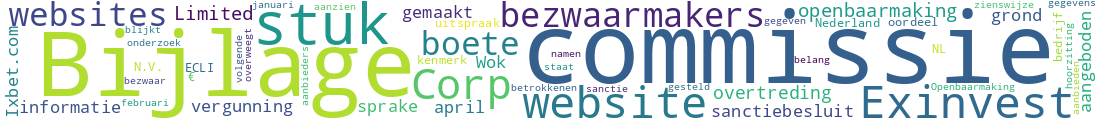


--------------------------------------------------------------------------------
CASE NAME: 7Red.com

--------------------------------------------------------------------------------
CASE NAME: L.S.A. B.V
  ecli_nl_rvs_2019_11_uitspraak_inzake_lob_lsa_bv.pdf
  besluit_tot_openbaarmaking.pdf
  besluit_last_onder_bestuursdwang_02112016_geanonimiseerd.pdf
  besluit_openbaarmaking_-_openbare_versie_op_briefpapier.pdf
  1528 words


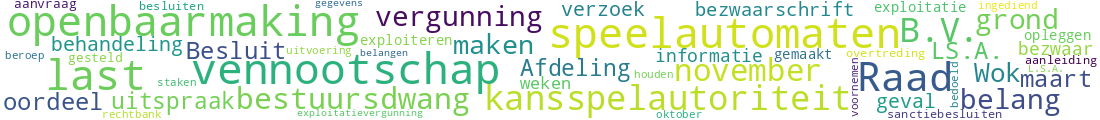


--------------------------------------------------------------------------------
CASE NAME: V.O.F. AULON
  besluit_v_o_f_aulon.pdf
  besluit_tot_openbaarmaking_v_o_f_aulon.pdf
  1382 words


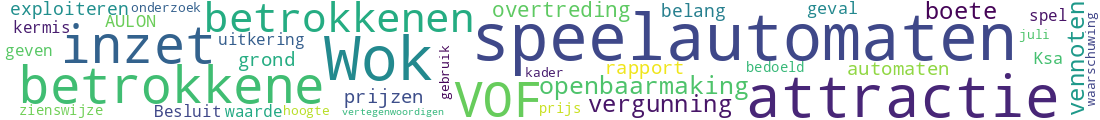


--------------------------------------------------------------------------------
CASE NAME: M-automaten exploitatie
  00_082_720_openbare_versie_last_onder_bestuursdwang.pdf
  00_082_721_openbare_versie_besluit_tot_opehbaarmaking.pdf
  875 words


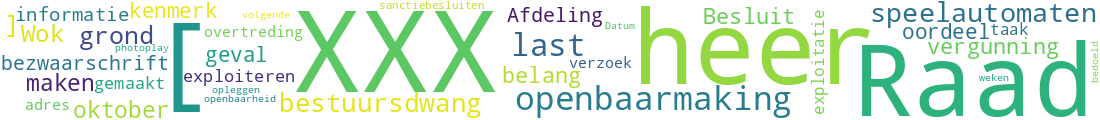


--------------------------------------------------------------------------------
CASE NAME: BankGiro Loterij N.V.
  besluit_intrekken_lod_1.pdf
  besluit_openbaarmaking_intrekking_lod_1.pdf
  besluit_op_bezwaar_last_onder_dwangsom_npl_bgl_en_vl.pdf
  besluit_tot_openbaarmaking_bob_npl_bgl_en_vd.pdf
  last_onder_dwangsom_bankgiro_loterij_n_v.pdf
  openbaarmaking_last_onder_dwangsom_bankgiro_loterij_n_v.pdf
  besluit_last_onder_dwangsom_gdl.pdf
  besluit_openbaarmaking_last_onder_dwangsom_gdl.pdf
  6593 words


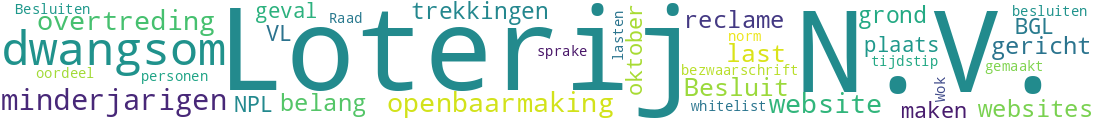


--------------------------------------------------------------------------------
CASE NAME: Belhuis _ Internetcafé Ephesus
  sanctiebesluit_belhuis_-_internetcafe_ephesus.pdf
  besluit_tot_openbaarmaking_belhuis_-_internetcafe_ephesus.pdf
  1873 words

--------------------------------------------------------------------------------
CASE NAME: Bet-at-home
  20190103-01_048_080_besluit_op_bezwaar.pdf
  20190103-01_048_077_besluit_tot_openbaarmaking.pdf
  sanctiebesluit_bet-at-home.pdf
  besluit_tot_openbaarmaking_bet-at-home.pdf
  6855 words

--------------------------------------------------------------------------------
CASE NAME: Betent B.V.
  15998_01-302-172_betent_sanctiebesluit_openbaar.pdf
  2304 words

--------------------------------------------------------------------------------
CASE NAME: Betent
  20230831_01-292-887_aanwijzing_betent_ov.pdf
  20230831_01-292-888_besluit_op_bezwaar_ov.pdf
  3657 words

------------------------------------------------------------------------

In [63]:
stop_mixed = []
stop_mixed.extend( wetsuite.extras.word_cloud.stopwords_nl ) # shouldn't be as necessary when you use the 'only nouns' code, but in case you don't
stop_mixed.extend( 'Kansspelautoriteit kansspelen artikel lid Wet raad bestuur besluit'.split() ) # extra stopwords - nouns that we decide are common to all cases and less interesting to see

def show_wordcloud(words):
    counts = wetsuite.extras.word_cloud.count_normalized( words, stopwords=stop_mixed )
    im = wetsuite.extras.word_cloud.wordcloud_from_freqs( counts, 1100, 120 )
    display( im )   # note: display() exists in the context of IPython notebooks.  Outside of notebooks you would probably im.save() instead.


# only show wordcloud image for first few cases, to keep this demo notebook size down  (the rest are still parsed, but only for the final word count)
num_wordcloud_cases = 6

num_cases, num_docs, num_pages, num_pars, num_words = 0, 0, 0, 0, 0

for case_i, case in enumerate( ks.data.values() ) :
    num_cases += 1

    print( 'CASE NAME: %s'%case['name'] )
    words = [] # collects interesting words for a case


    for doc in case['docs']:
        print( '  %s'%wetsuite.helpers.format.url_basename(doc['url']) )

        paragraphs = body_text_groups( doc )

        num_docs  += 1
        num_pages += len( doc['pages'] )
        num_pars  += len( paragraphs )

        for paragraph in paragraphs:
            for token in dutch_parser( paragraph ):
                num_words += 1
                if token.pos_ in ('NOUN','PROPN', 'VERB'):
                    words.append( token.text )

    if len(words) > 0: # there is one case with missing download links, so no actual data, ignore it...
        print( '  %d words'%(len(words))  )

        # only create the wordcloud for the first bunch, to not spam too much
        if case_i < num_wordcloud_cases: 
            show_wordcloud( words )
        # ...but don't break off, so that we can still get a total count
    print()
    print('-'*80)



print( '\n\nTotal number of   cases:%d  documents:%d   pages:%d   text fragments:%d   words:%d'%( num_cases, num_docs, num_pages, num_pars, num_words) )